In [1]:
#some style formatting
from IPython.display import HTML
style = '''<style>
div.abstract_text {text-align: justify;text-justify: inter-word;}
div.text {text-align: justify; text-justify: inter-word;}
</style>'''
HTML(style)


<img typeof="foaf:Image" src="static/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# ML Analysis for <i>T. brucei</i>

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee
   
## Motivation
<span>
<div class=text>
A clever experiment in 2011 used high-throughput phenotyping approach (RIT-seq) to map the fitness-costs associated with RNAi. An RNAi plasmid library, containing randomly sheared genomics fragments was used to create an inducible library. After transfection, the library was grown under non-inducing and inducing conditions in T. brucei. By comparing the read counts of the library before and after induction, is possible to identify essential genes, ie genes with more reads in the un-induced sample respect to the induced sample. 
</div> 

In [2]:
#set up code
%load_ext autoreload
%autoreload 2

In [3]:
from mylib import scripts
%run mylib/scripts.py
np.random.seed =1976

Using TensorFlow backend.


In [4]:
import pandas as pd
#load the dataset
#final_df = pd.read_csv('indata/GenesByTaxon_Summary_43.zip',sep='\t')
tryp_df = pd.read_csv(os.path.join('input','GenesByTaxon_Summary_45.zip'), sep='\t')
#just to store the gene description
tryp_df = tryp_df[['Gene ID','Product Description','Ortholog Group']]
print(tryp_df.shape)
tryp_df.head()

(11832, 3)


,Gene ID,Product Description,Ortholog Group
0,Tb04.24M18.150,"hypothetical protein, conserved",OG5_143945
1,Tb04.3I12.100,hypothetical protein,OG5_tbru|Tb04.3I12.100
2,Tb05.30F7.410,hypothetical protein,OG5_tbru|Tb05.30F7.410
3,Tb05.5K5.10,"conserved hypothetical protein, conserved (fra...",OG5_143091
4,Tb05.5K5.100,"hypothetical protein, conserved",OG5_167743


In [5]:
#we take only one gene x ortholog group
selection = tryp_df.drop_duplicates('Ortholog Group')

#### RNA-Seq phenotyping
Alsford S, 2011<p>
High-throughput phenotyping using parallel sequencing of RNA interference targets in the African trypanosome
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/21363968">21363968</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/dataset/DS_3f5188c7a8">TryTripDB</a>
    
The dataset deposited in TriTrypDB contain a mixture of numbers and numbers followed by an asterisks.we Don't know why but can't use it for now.   

In [6]:
#experiment columns
['BFd3/Tet- (CDS only)', 'BFd6/Tet-',  'PF/Tet-', 'difn/Tet-' 
'BFd3/Tet- (CDS only)', 'BFd6/Tet- (CDS only)',
'PF/Tet- (CDS only)', 'difn/Tet- (CDS only)']

['BFd3/Tet- (CDS only)',
 'BFd6/Tet-',
 'PF/Tet-',
 'difn/Tet-BFd3/Tet- (CDS only)',
 'BFd6/Tet- (CDS only)',
 'PF/Tet- (CDS only)',
 'difn/Tet- (CDS only)']

## Modelling of protein essentiality



In [7]:
#we use only protein coding genes
ml_dfs=pd.read_csv(os.path.join('output', 'final_df.csv.gz'),index_col=[0])
ml_dfs = ml_dfs[ml_dfs['SF_Prot_Coding']==1]
del ml_dfs['SF_Prot_Coding']

In [8]:
#we use TryTripDB to map the genes reported in Sup File 1 of Alsford S et, 2011
mapping = pd.read_csv(os.path.join('input','essential','mapping.txt'),sep='\t')
#we extract the z-score computed with the DEGseq package in Alsford S et, 2011
gene_classes = pd.read_csv(os.path.join('input','essential','gene_score.txt'),sep='\t')
mapping = mapping.merge(gene_classes,left_on='Input ID',right_on='Gene_id')
mapping = mapping.drop_duplicates('Ortholog Group')
#mapping['target'].value_counts()

In [9]:
mapping = mapping[['Gene ID','Z_score']]
mapping.head()

,Gene ID,Z_score
0,Tb04.24M18.150,0.59
1,Tb04.3I12.100,-1.18
2,Tb05.30F7.410,-4.18
3,Tb06.3A7.270,-4.77
4,Tb06.3A7.960,1.81


In [10]:
ml_dfs = ml_dfs.merge(mapping,left_on='Gene ID',right_on='Gene ID',how='inner')

In [11]:
#ml_dfs.isna().sum(axis=1).value_counts()

In [12]:
#we use only genes with a low counts of missing values
#ml_dfs = ml_dfs[ml_dfs.isna().sum(axis=1)<5]

In [13]:
ml_dfs.head()

,Gene ID,EF_merged_PCF_BSF,EF_LSvSS,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,PF_ofer_w8: F Entropy,PF_ofer_w8: G Entropy,PF_ofer_w8: K Entropy,PF_ofer_w8: M Entropy,PF_ofer_w8: N Entropy,PF_ofer_w8: Total Entropy,PF_polarizability aaScale - Window size:17 Average-Trimmed MAX,PF_polarizability aaScale - Window size:17 MAXIMUM,PF_polarizability aaScale - Window size:7 MAXIMUM,Z_score
0,Tb04.24M18.150,0.402848,NaN,0.000000,0.5,0.5,5.870638,7.631146,229.80530,-1.0,...,2.385654,3.339850,2.754888,3.432959,3.252387,2.844283,0.143641,0.170043,0.184429,0.59
1,Tb04.3I12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,-1.0,...,1.405515,2.990477,2.846087,3.916477,2.916477,2.618204,0.173773,0.199140,0.200857,-1.18
2,Tb05.30F7.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,-1.0,...,3.152952,2.645992,2.493989,3.593525,3.152952,2.916539,0.141305,0.163202,0.169000,-4.18
3,Tb06.3A7.270,NaN,NaN,0.263034,0.5,9.0,NaN,7.002362,33.51486,-1.0,...,2.656624,3.019194,3.229613,3.217739,2.593888,2.912492,0.137135,0.168229,0.177429,-4.77
4,Tb06.3A7.960,-1.430681,NaN,0.263034,8.0,3.0,7.355485,7.543305,91.99412,-1.0,...,2.603699,4.106199,3.066671,3.231730,2.816693,2.860678,0.140238,0.166865,0.176143,1.81


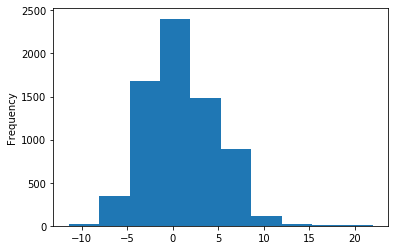

In [14]:
ml_dfs['Z_score'].plot(kind='hist')

In [15]:
ml_dfs.sort_values('Z_score').head()

,Gene ID,EF_merged_PCF_BSF,EF_LSvSS,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,PF_ofer_w8: F Entropy,PF_ofer_w8: G Entropy,PF_ofer_w8: K Entropy,PF_ofer_w8: M Entropy,PF_ofer_w8: N Entropy,PF_ofer_w8: Total Entropy,PF_polarizability aaScale - Window size:17 Average-Trimmed MAX,PF_polarizability aaScale - Window size:17 MAXIMUM,PF_polarizability aaScale - Window size:7 MAXIMUM,Z_score
35,Tb927.1.1230,NaN,NaN,0.378512,10.0,0.5,NaN,NaN,0.000000,-1.0,...,2.658963,2.717066,3.048910,3.352302,2.640104,2.921105,0.136699,0.167115,0.176429,-11.43
5250,Tb927.7.340,NaN,NaN,0.125531,11.0,0.5,5.705368,NaN,0.000000,-1.0,...,2.375867,3.067744,3.067744,3.183222,2.926882,2.873144,0.147260,0.170979,0.183857,-10.86
4052,Tb927.4.3360,NaN,NaN,0.125531,9.0,0.5,6.775503,7.074704,84.052520,-1.0,...,2.840219,3.239827,2.936435,2.987061,2.706953,2.919227,0.140345,0.172692,0.182286,-10.47
249,Tb927.10.10090,-0.204270,NaN,0.263034,5.0,0.5,6.991785,7.289354,25.857680,-1.0,...,2.553427,3.177918,3.062441,3.107528,2.633597,2.909657,0.145437,0.174176,0.184429,-9.44
6696,Tb927.9.4080,-0.014103,0.3,0.125531,3.0,0.5,7.973543,8.096907,0.048094,-1.0,...,2.967432,2.591565,3.102362,3.371065,2.598198,2.909299,0.133051,0.169883,0.176857,-9.38


In [16]:
#ml_dfs.sort_values('Z_score').head(500)['Z_score'].describe()

In [54]:
to_sample=400
ml_df = pd.concat([ml_dfs.sort_values('Z_score').tail(to_sample),
                   ml_dfs.sort_values('Z_score').head(to_sample)])

In [55]:
ml_df['target'] = [1 for n in range(to_sample)]+[0 for n in range(to_sample)]

In [56]:
ml_df['target'].value_counts()

1    400
0    400
Name: target, dtype: int64

In [57]:
#ml_df = ml_df[[n for n in ml_df.columns if n.startswith('PF_') ]+['target']]

In [58]:
X = ml_df.dropna(subset=['target'])
X.head()

,Gene ID,EF_merged_PCF_BSF,EF_LSvSS,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,PF_ofer_w8: G Entropy,PF_ofer_w8: K Entropy,PF_ofer_w8: M Entropy,PF_ofer_w8: N Entropy,PF_ofer_w8: Total Entropy,PF_polarizability aaScale - Window size:17 Average-Trimmed MAX,PF_polarizability aaScale - Window size:17 MAXIMUM,PF_polarizability aaScale - Window size:7 MAXIMUM,Z_score,target
5085,Tb927.7.1460,0.085868,-0.64,0.263034,0.5,10.0,7.082324,7.203450,0.908191,-1.0,...,3.333901,3.769116,2.852774,2.930179,2.868887,0.143665,0.166181,0.176143,6.62,1
1958,Tb927.11.13240,NaN,NaN,NaN,NaN,NaN,6.502785,6.757865,152.491500,-1.0,...,2.700440,3.424805,2.590815,3.041477,2.926139,0.140119,0.169133,0.182714,6.62,1
5927,Tb927.8.4210,-0.263934,NaN,0.137504,0.5,3.0,8.456597,8.838866,0.788485,-1.0,...,3.353254,3.666412,3.388878,2.501353,2.889866,0.139668,0.158617,0.169143,6.63,1
5942,Tb927.8.4370,-1.048078,NaN,0.263034,3.0,0.5,8.302902,7.274277,41.415264,-1.0,...,2.863938,3.143222,3.420332,2.649814,2.919698,0.137855,0.174937,0.180571,6.63,1
2312,Tb927.11.16720,NaN,NaN,2.502500,8.0,0.5,6.717671,6.858151,0.160470,-1.0,...,3.690316,3.062284,3.242856,2.149747,2.901382,0.155265,0.180143,0.186429,6.64,1


In [59]:
X=X.dropna(axis=0, how='all')
X=X.dropna(axis=1, how='all')


### Creating the actual dataset

In [60]:
y=X['target']
del X['target']
del X['Gene ID']
del X['Z_score']
#X=X[[n for n in X.columns if n.startswith('PF_')]]
print(X.shape,y.shape)
y.value_counts()

(800, 1400) (800,)


1    400
0    400
Name: target, dtype: int64

When the number of descriptors (columns of the dataset) is similar or exceed the number of training instances (rows in the dataset), ML algorithms are prone to overfitting, i.e. learning associations with the response variable (fast or long half-lives) originating just by chance [12]. Intending to reduce the number of descriptors, we eliminated 277 features that correlate to other features with a Pearson correlation coefficient of 0.75 or higher. We 

In [61]:
# very crude removal of high correlated features
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print('Removing:',len(to_drop), 'features')

Removing: 286 features


In [62]:
print(X.shape)
X=X.drop(to_drop, axis=1)
print(X.shape)
#X = X[[n for n in X.columns if 'Mutability' not in n ]]

(800, 1400)
(800, 1114)


### Imput missing values

We imputed missing values in the categorical variables with -1. On the other hand, the missing values of continue variables where replaced by the variable means. 

In [63]:
#Strategy to input missing values / optional but usefull for 
#visualization of the feature importance
X = scripts.input_missing_values(X, X.columns)

### First Train

We then trained a random forest algorithm implemented in LightGBM [33] to discriminate between proteins with fast or slow half-lives. Before training, we removed 35% of the training instances (blind) to evaluate the training progression on a subset of instances never seen by the predictor. The LightGBM algorithm was trained with a three-fold cross-validation (CV) strategy. With this strategy, the input data is divided into 3 subsets (also known as folds). Afterwards, The ML algorithm is trained on all but one of the subsets and evaluated on the subset that was not used for training. The process repeats 3 times, with a different subset reserved for evaluation (and excluded from training) each time. In this way, all the data is used once for both training and evaluation. The LightGBM algorithm starts the training with just one tree in the random forest and evaluates the prediction performance using the evaluation subset. With an iterative process, the algorithm adds one tree to the random forest and evaluates the prediction performance again. This process continues until the addition of a tree to the random forest model does not improve the prediction performance (early stopping). At each step, The LightGBM algorithm evaluates the prediction performance using the receiver operating characteristic curve (ROC) area under the curve (AUC) score (mean 0.75). 

In [64]:
#??scripts.run_lgb

DataSet size
X_train: (520, 1114) X_test: (280, 1114) y_train: (520,) y_test (280,) 
 1    140
0    140
Name: target, dtype: int64


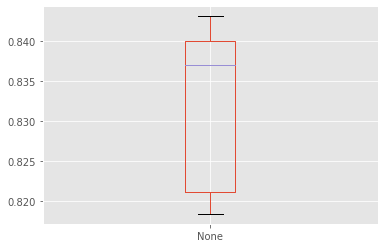

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       147
           1       0.79      0.83      0.81       133

    accuracy                           0.81       280
   macro avg       0.81      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280

1 dummy_roc_auc_score: 0.5214987714987716
1 blind_roc_auc_score: 0.8114930182599355

Confusion Matrix
[[117  30]
 [ 23 110]]


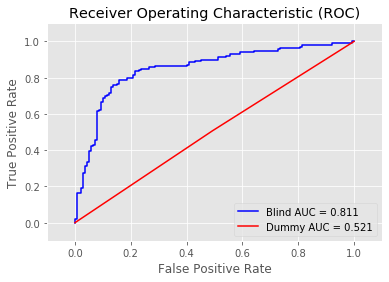

{'objective': 'binary',
 'min_data_in_leaf': 5,
 'n_jobs': 8,
 'boosting_type': 'rf',
 'bagging_fraction': 0.7,
 'feature_fraction': 0.7,
 'bagging_freq': 1,
 'n_estimators': 22,
 'max_depth': 5}

In [65]:
params = {
            'objective': 'binary',
            'min_data_in_leaf':5,
            'n_jobs':8,
            'boosting_type':"rf",
            'bagging_fraction':0.7,
            'feature_fraction':0.7,
            'bagging_freq' : 1,
            'n_estimators' : 100,
            'max_depth' : 5
            }

fitted_model, params, blind_score = scripts.run_lgb(X, y, params)
params

At the end of the CV strategy, a new model is trained with all the data used for the CV step and evaluated on the blind dataset (AUC = 0.679). The blind ROC AUC score suggested that the algorithm is separating proteins with fast and long half-lives better than random.  The number of trees to evaluate the model on the blind dataset was chosen from the CV strategy. At each CV round, the algorithm records the number of trees used.  By inspecting the training history, we selected 14 trees equal to the maximum number of trees used in any of the three CV steps. This optimised model, respect to the number of tree in the forest, was used to shrink further the number of relevant features. 

### Feature Selection
#### Boruta
We first applied the Boruta methods [34] to identify all the features carrying information usable for prediction (82). Briefly, the Boruta algorithm randomises all descriptors in the dataset and evaluates the randomise features, looking if they are less or more important of the real features in separating fast and slow turnover protein. If the real features are better than the shuffled copies, they are marked as important.

In [66]:
print('boruta will take some times to run')
rf_params = {'class_weight':'balanced',
             'max_depth':params['max_depth'],
             'n_jobs':8, 'n_estimators':params['n_estimators'],
             'min_samples_leaf':params['min_data_in_leaf']
            }

#X.fillna(X.mean()).replace(-np.inf,-999).replace(np.inf,999)
score_df = scripts.boruta_select(
    X, y, rf_params)
selected_features = list(score_df[score_df['support']]['f'])
print(selected_features)

boruta will take some times to run


[ True  True  True ... False  True False]
['EF_merged_PCF_BSF', 'EF_LSvSS', 'EF_CellCycle_min_max', 'EF_CellCycle_max', 'EF_CellCycle_min', 'EF_Abundance_BSF', 'EF_MW_fc', 'EF_prot_BSF_to_PCF_1_min_max', 'EF_prot_BSF_to_PCF_1_max', 'EF_prot_BSF_to_PCF_1_min', 'EF_ma_BSF_to_PCF_2_max', 'EF_fc_glucose_1', 'EF_fc_glucose_3', 'EF_RNA_CellCycle_min_max', 'EF_RNA_BSF_to_PCF_sen_min', 'EF_Abundance_s_PCF_mRNA', 'EF_RiboP_BSF_vs_PCF', 'EF_heatShock', 'EF_Nuclear_enriched', 'SF_Ortholog_count', 'SF_Transcript_Length', 'SF_SNPs2', 'SF_SNPs6', 'ELM_DOC_USP7_UBL2_3', 'ELM_MOD_SUMO_rev_2', 'ELM_TRG_Pf-PMV_PEXEL_1', 'PF_AA: C Frequency', 'PF_AA: I Frequency', 'PF_AA: K Frequency', 'PF_AA: P Frequency', 'PF_AA: Q Frequency', 'PF_AA: W Frequency', 'PF_Charge Distribution1100', 'PF_Charge Distribution2001', 'PF_Charge Distribution3001', 'PF_Disorder Propensity Composition:1', 'PF_Flexibility (B-values):Max', 'PF_Hydrophobicity Distribution1001', 'PF_Hydrophobicity Distribution1100', 'PF_Mutability aaSc

second round
DataSet size
X_train: (520, 70) X_test: (280, 70) y_train: (520,) y_test (280,) 
 1    140
0    140
Name: target, dtype: int64


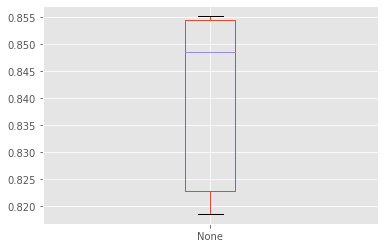

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       151
           1       0.74      0.80      0.77       129

    accuracy                           0.78       280
   macro avg       0.78      0.78      0.77       280
weighted avg       0.78      0.78      0.78       280

1 dummy_roc_auc_score: 0.5392877187611612
1 blind_roc_auc_score: 0.7767082499101597

Confusion Matrix
[[114  37]
 [ 26 103]]


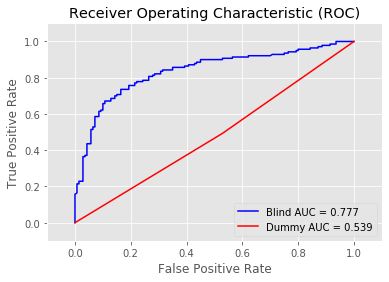

In [67]:
#second round
print('second round')
fitted_model, params , blind_score= scripts.run_lgb(X[selected_features],y, params)

#### ELI5
In a further step feature selection, we applied a different permutation importance strategy implemented in the ELI5 python package [35]. In this case, only one feature at a time is randomised, and the performance of the model evaluated. If the performance of the model decreases after randomisation (lower AUC score), the feature is annotated as important. The randomization process was performed three times with a different random seed and the average feature score difference stored. As the ELI5 strategy is more computationally expensive than the Boruta algorithm, the former was executed before the latter. 

In [68]:
#??scripts.eli_select

In [69]:
# ELI5 f selection
print('ELI5 will take some times to run')
score_df = scripts.eli_select(X[selected_features], y, params)

ELI5 will take some times to run


In [70]:
#ELI5 df
score_df.sort_values('fimp',ascending=False).head(15)

,fimp,f
5,0.190125,EF_Abundance_BSF
19,0.026000,SF_Ortholog_count
11,0.010000,EF_fc_glucose_1
69,0.006625,PF_ofer_w8: AA: C Frequency
24,0.006625,ELM_MOD_SUMO_rev_2
61,0.006125,PF_ofer14: Mirror K-mer : CG
7,0.006000,EF_prot_BSF_to_PCF_1_min_max
36,0.004875,PF_Flexibility (B-values):Max
59,0.004625,PF_ofer14: Mirror K-mer : CD
16,0.004125,EF_RiboP_BSF_vs_PCF


final round
DataSet size
X_train: (520, 2) X_test: (280, 2) y_train: (520,) y_test (280,) 
 1    140
0    140
Name: target, dtype: int64


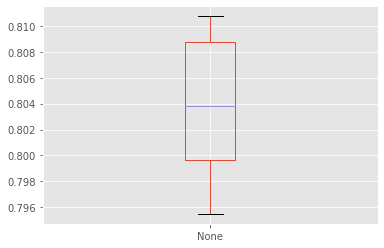

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       139
           1       0.76      0.76      0.76       141

    accuracy                           0.76       280
   macro avg       0.76      0.76      0.76       280
weighted avg       0.76      0.76      0.76       280

1 dummy_roc_auc_score: 0.4678423766015007
1 blind_roc_auc_score: 0.760727588142252

Confusion Matrix
[[106  33]
 [ 34 107]]


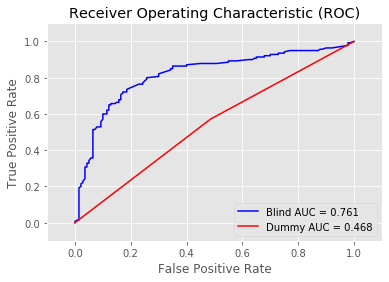

In [78]:
selected_features = list(score_df[score_df['fimp']>0.013]['f'])

#final round
print('final round')
fitted_model, params, blind_score = scripts.run_lgb(X[selected_features],y, params)    

In [72]:
len(selected_features), selected_features

(2, ['EF_Abundance_BSF', 'SF_Ortholog_count'])

### Feature Importance

The importance of these selected features was visualised with the SHAP (SHapley Additive exPlanations) values. The SHAP values aggregate five different rank feature methods into one, by using an algorithm first developed for game theory. This algorithm aims at explaining the prediction of an instance (protein) by computing the contribution of each feature to the prediction. In particular, this framework assigns to each protein a SHAP value (positive for fast half-lives, negative for long half-lives), and the absolute sum of the SHAP values adds to the feature importance. Consequently, the visualization of the feature importance can be visualised along with the feature effect.(https://github.com/slundberg/shap).

In [73]:
#Now we use the SHAP scoring system to visualise 
#the most important features for the model
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X[selected_features])
#shap.summary_plot(shap_values, 
                  #train[train_features],
                  #max_display=100)

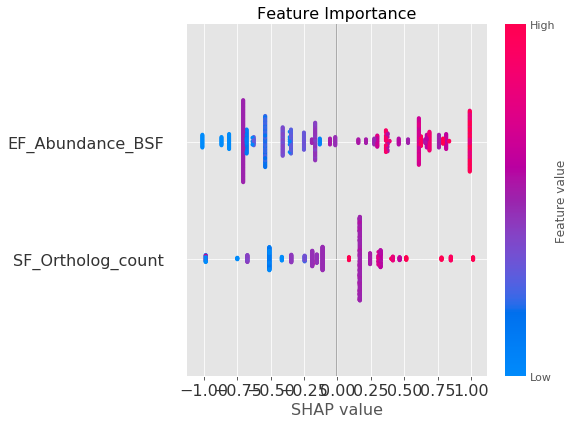

In [79]:
plt.style.use('ggplot')
shap.summary_plot(shap_values, 
                  X[selected_features], 
                  feature_names=troncate_name(list(X[selected_features].columns)),
                  max_display=10,show=False)

f = plt.gcf()
f.set_size_inches(8,6)
plt.title('Feature Importance',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figures','example_2','Fig_1.png'))
plt.savefig(os.path.join('figures','example_2','Fig_1.svg'))
plt.savefig(os.path.join('figures','example_2','Fig_1.eps'), format='eps')
plt.show()
#print(r)

In this figure the position of the feature on the y-axis of is determined by the feature importance, and the dots (protein/training instances) on the x-axis are arranged accordingly to the SHAP values. The dots are also jittered in the y-axis direction to assess the distribution. The colour code of the dots reflects the value of the feature from low (blue) to high (red). This visualization highlights the relationship between the value of a feature and the impact on the prediction. For example, training instances with low values of the protein abundance in the BSF life stage ('EF_Abundance_BSF') have the highest SHAP values, meaning that low protein abundance values are pushing the model towards a fast half-life prediction.

### Feature Analysis
The exact shape of this relationship is visualized in Figure 2 where we plotted on the x-axis the feature values and on the y-axis the SHAP values for each protein and feature in the training dataset. 

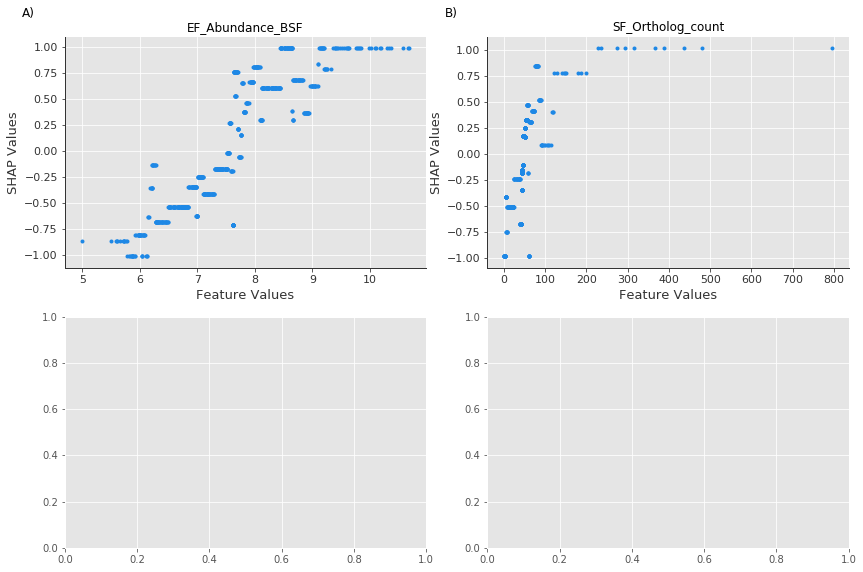

In [77]:
fig,axes = plt.subplots(figsize=(12,8), nrows=2, ncols=2)
labels = ['A','B','C','D']

mapping_dict = {
    0:[0,0],
    1:[0,1],   
}

for n, f in enumerate(selected_features):
    a,b=mapping_dict[n][0],mapping_dict[n][1]
    if f == 'EF_CellCycle_min':
        shap.dependence_plot(n, shap_values, 
                    X[selected_features],
                             interaction_index =None, 
                             x_jitter=0.2,
                             show=False,ax=axes[a][b])
    else:
        shap.dependence_plot(n, shap_values, 
                    X[selected_features],
                            interaction_index =None,
                            show=False,
                            ax=axes[a][b])
    
    axes[a][b].set_title(f, fontsize=12)
    axes[a][b].set_ylabel('SHAP Values')
    axes[a][b].set_xlabel('Feature Values')
    axes[a][b].text(-0.1, 1.1, labels[n]+')', 
                               horizontalalignment='center',
               verticalalignment='center',
               transform=axes[a][b].transAxes,fontsize=12)
    #if n == 1:
    #    axes[a][b].set_xlim(-0.1,100)
    #    axes[a][b].set_ylim(-0.2,0.2)
    #if n == 2:
        
    #    axes[a][b].set_ylim(-0.4,0.6)

    
plt.tight_layout()
plt.savefig(os.path.join('figures','example_2','Fig_2.png'))
plt.savefig(os.path.join('figures','example_2','Fig_2.svg'))
plt.savefig(os.path.join('figures','example_2','Fig_2.eps'), format='eps')
plt.show()


In [80]:
!jupyter nbconvert --to html_toc TriTrypDB_ML_1.2.ipynb

[NbConvertApp] Converting notebook TriTrypDB_ML_1.2.ipynb to html_toc
[NbConvertApp] Support files will be in TriTrypDB_ML_1.2_files\
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Making directory TriTrypDB_ML_1.2_files
[NbConvertApp] Writing 346597 bytes to TriTrypDB_ML_1.2.html


In [40]:
#corr['Z_score'].sort_values()